In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time

# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load dataset
df_crimes_summary = pd.read_csv('crimes_summary.csv', parse_dates=['occurred_date_time'])

In [ ]:
#this dataframe list top ten crimes which occur in the zip code 78701 under census_tract 11 which falls under council_district 9.
#Top ten crimes are : ASSAULT BY CONTACT,ASSAULT WITH INJURY,BURGLARY OF VEHICLE,CRIMINAL MISCHIEF,DISTURBANCE - OTHER,DWI,POSS OF DRUG PARAPHERNALIA,THEFT,VIOL CITY ORDINANCE - OTHER,WARRANT ARREST NON TRAFFIC

In [3]:
df_crimes_summary.head()

,incident_report_number,crime_type,ucr_code,family_violence,location_type,address,zip_code,council_district,sector,district,...,clearance_status,clearance_date,occurred_date_time,reported_date_time,month,year,hour,year_month,occurred_day,cal_month
0,20223650465,ASSAULT WITH INJURY,900,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,700 BLOCK E 7TH ST,78701,9,GE,2,...,N,2023-01-03T00:00:00.000,2022-12-31 09:24:00,2022-12-31 09:24:00,December,2022,9,2022-12,31,12
1,20223650192,DWI,2100,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,E 9TH ST / N IH 35 SVRD SB,78701,9,CH,2,...,C,2022-12-31T00:00:00.000,2022-12-31 02:39:00,2022-12-31 02:39:00,December,2022,2,2022-12,31,12
2,20223641477,ASSAULT BY CONTACT,902,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,708 E 6TH ST,78701,9,GE,2,...,N,2023-01-03T00:00:00.000,2022-12-30 23:40:00,2022-12-30 23:40:00,December,2022,23,2022-12,30,12
3,20223641378,DISTURBANCE - OTHER,3401,N,RESTAURANT,414 E 6TH ST,78701,9,GE,2,...,NaN,NaN,2022-12-30 22:28:00,2022-12-30 23:01:00,December,2022,22,2022-12,30,12
4,20223640858,ASSAULT WITH INJURY,900,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,400 E 8TH ST,78701,9,GE,1,...,N,2023-01-04T00:00:00.000,2022-12-30 15:55:00,2022-12-30 15:55:00,December,2022,15,2022-12,30,12


In [4]:
df_crimes_types=df_crimes_summary[['occurred_date_time','crime_type','hour','occurred_day','cal_month','year_month','year']]

In [5]:
df_crimes_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30680 entries, 0 to 30679
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   occurred_date_time  30680 non-null  datetime64[ns]
 1   crime_type          30680 non-null  object        
 2   hour                30680 non-null  int64         
 3   occurred_day        30680 non-null  int64         
 4   cal_month           30680 non-null  int64         
 5   year_month          30680 non-null  object        
 6   year                30680 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.6+ MB


In [87]:

df_burglary=df_crimes_types.loc[(df_crimes_types['crime_type'] == 'BURGLARY OF VEHICLE')]

In [88]:
df_burglary.head(5)

,occurred_date_time,crime_type,hour,occurred_day,cal_month,year_month,year
5,2022-12-30 00:00:00,BURGLARY OF VEHICLE,0,30,12,2022-12,2022
12,2022-12-27 17:00:00,BURGLARY OF VEHICLE,17,27,12,2022-12,2022
27,2022-12-21 16:35:00,BURGLARY OF VEHICLE,16,21,12,2022-12,2022
29,2022-12-21 02:00:00,BURGLARY OF VEHICLE,2,21,12,2022-12,2022
30,2022-12-19 08:46:00,BURGLARY OF VEHICLE,8,19,12,2022-12,2022


In [89]:
df_burglary['occurred_date'] = pd.to_datetime(df_burglary['occurred_date_time'], format='%Y-%m-%d').dt.floor('D')

In [90]:
df_burglary.dtypes

occurred_date_time    datetime64[ns]
crime_type                    object
hour                           int64
occurred_day                   int64
cal_month                      int64
year_month                    object
year                           int64
occurred_date         datetime64[ns]
dtype: object

In [91]:
df_burglary.shape

(2963, 8)

In [92]:
df_burglary_gpby_date=df_burglary.groupby(['year_month']).agg(
    burglary_count=('crime_type', 'count'),
    
 ).reset_index()

In [94]:
df_burglary_gpby_date.sort_values(by = ['year_month'], ascending = [True])

,year_month,burglary_count
0,2013-01,21
1,2013-02,19
2,2013-03,20
3,2013-04,14
4,2013-05,41
...,...,...
115,2022-08,26
116,2022-09,24
117,2022-10,32
118,2022-11,24


In [95]:
df_burglary_gpby_date.describe()

,burglary_count
count,120.000000
mean,24.691667
std,10.868036
min,9.000000
25%,17.000000
50%,22.500000
75%,31.000000
max,57.000000


In [96]:
fig = px.line(df_burglary_gpby_date, x='year_month', y='burglary_count', title="Count of Burglary of Vehicles 2013-2022 for zipcode 78701",template='plotly_dark')

fig.show()

In [97]:
df_burglary_gpby_date['year_month'] = pd.to_datetime(df_burglary_gpby_date['year_month'])

In [98]:
df_burglary_gpby_date.set_index('year_month',inplace=True)

In [99]:
df_burglary_gpby_date.head()

,burglary_count
year_month,
2013-01-01,21
2013-02-01,19
2013-03-01,20
2013-04-01,14
2013-05-01,41


### TIMES SERIES for BURGLARY of Vehicle

In [100]:
y = df_burglary_gpby_date['burglary_count']

In [101]:
display(type(y), y.dtype)

pandas.core.series.Series

dtype('int64')

<AxesSubplot:xlabel='year_month'>

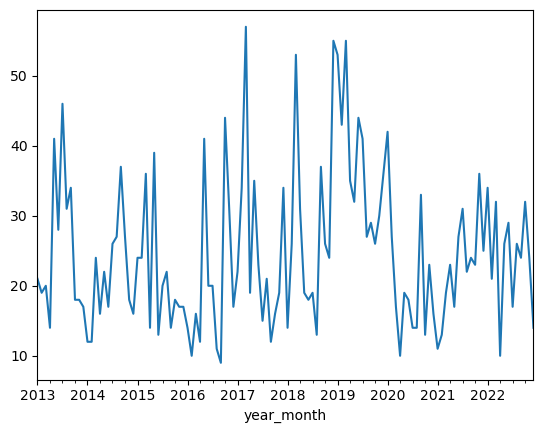

In [102]:
y.plot()

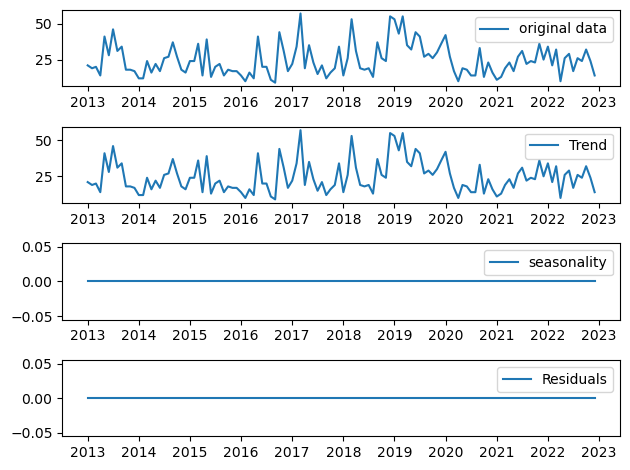

In [103]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition= seasonal_decompose(x=df_burglary_gpby_date['burglary_count'], model='additive', extrapolate_trend='freq', period=1)
#decomposition= seasonal_decompose(y)
# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### Testing for Stationarity using KPSS<a id='stationarity_test'>
    Kwiatkowski-Phillips-Schmidt-Shin Test

In [104]:
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(df_burglary_gpby_date, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  0.15156486534887906
p-value:  0.1
Number of Lags:  4
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since our p-value is higher than 0.05, we should  fail to reject the Null hypothesis and deduce the stationarity of our data.



### ADFuller test to test for stationarity<a id='adfuller_test'>

In [105]:
from statsmodels.tsa.stattools import adfuller

In [106]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")



In [107]:
adf_test(df_burglary_gpby_date)

Augmented Dickey-Fuller Test: 

ADF test statistic       -2.549141
p-value                   0.103971
# lags used              12.000000
# observations          107.000000
critical value (1%)      -3.492996
critical value (5%)      -2.888955
critical value (10%)     -2.581393

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is NOT STATIONARY


#### KPSS shows Stationarityin the data whereas ADFuller test shows non-stationarity

In [108]:
# Declare a variable called y_log
y_log = np.log(df_burglary_gpby_date)

<AxesSubplot:xlabel='year_month'>

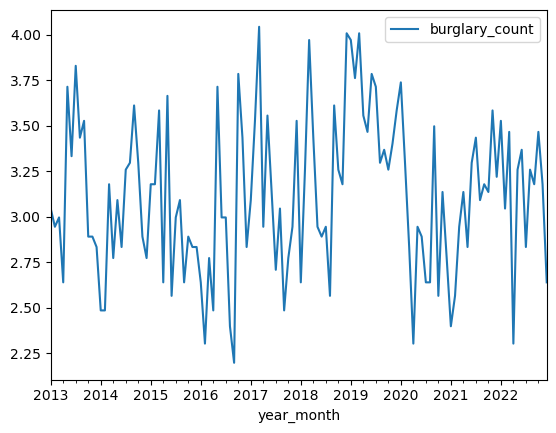

In [109]:
y_log.plot() # to achieve constant variance

In [110]:
y_diff=y_log.diff().dropna()

<AxesSubplot:xlabel='year_month'>

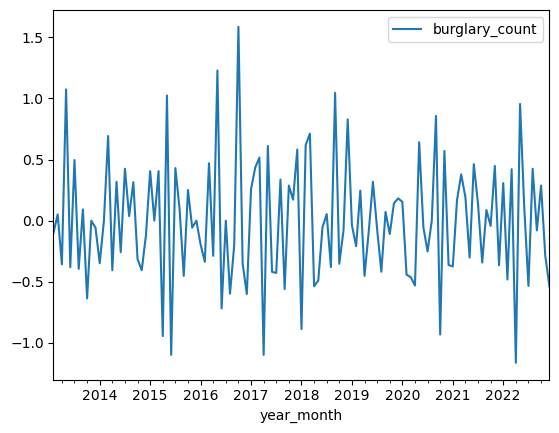

In [111]:
y_diff.plot() # to achieve constant mean

In [112]:
kpss(y_diff)

(0.0760965766683115,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [116]:
adf_test(y_diff)

Augmented Dickey-Fuller Test: 

ADF test statistic       -4.721014
p-value                   0.000077
# lags used              10.000000
# observations          108.000000
critical value (1%)      -3.492401
critical value (5%)      -2.888697
critical value (10%)     -2.581255

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is STATIONARY


In [128]:

test_size = 24

X_train, X_test = df_burglary_gpby_date[:-test_size], df_burglary_gpby_date[-test_size:]
y_train, y_test = np.array(range(X_train.shape[0])), np.array(range(X_train.shape[0], df_burglary_gpby_date.shape[0]))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((96, 1), (96,), (24, 1), (24,))

Text(0.5, 1.0, 'Burglary of Vehicles train and test sets')

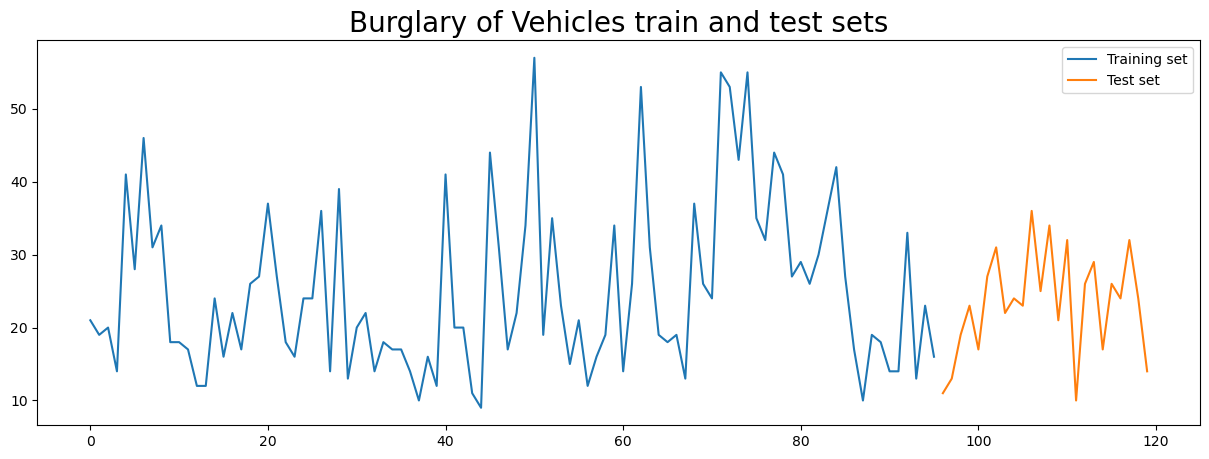

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(y_train, X_train, label='Training set')
ax.plot(y_test, X_test, label='Test set')
plt.legend()
plt.title('Burglary of Vehicles train and test sets', size=20)

### Simple Forecast Methods<a id='simple_forecast_methods'>
    
Based on Rob J Hyndman and George Athanasopoulos"<br />
Forecasting: Principles and Practice; 3rd Edition<br />
https://otexts.com/fpp3/

###  MEAN Method<a id='mean_method'>

In [168]:
#forecast of all future values is equal to mean of historical data. 

forecast = np.mean(y)
print("Forecast value for the next month: ",round(forecast))

Forecast value for the next month:  25


In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

### NAIVE Method<a id='naive_method'>

In [170]:
dd= np.asarray(X_train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

### SNAIVE Method<a id='snaive_method'>

### DRIFT Method<a id='drift_method'>

### data is stationary - draw the autocorrelation and partial autocorrelation graph of the data.

Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p. 
Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.  

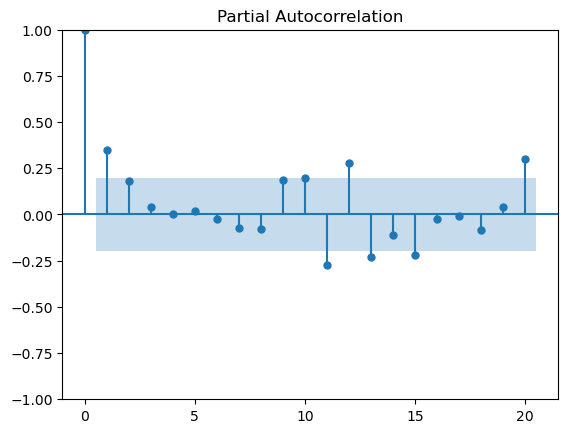

In [120]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.array(X_train.burglary_count))
plt.show()

### From the above graph, The partial autocorrelation plot (which assists us in determining the AR term) drops  after one lag (we do not count the first lag). This implies that we should use an AR(1) model.

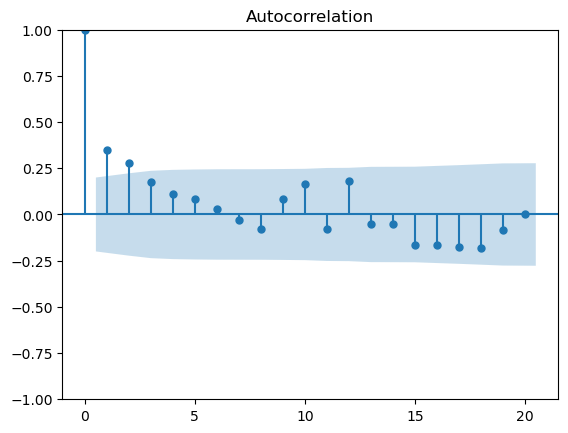

In [121]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(X_train.burglary_count))
plt.show()

### From the above plot, I will consider MA(2) model

In [122]:
from pmdarima.arima.utils import ndiffs

ndiffs(df_burglary_gpby_date)

0

#####  order of differencing as per above result. d=0

In [123]:
from pmdarima.arima import nsdiffs
nsdiffs(df_burglary_gpby_date,12)

0

##### No seasonality as per above result

### Therefore the values of p, d and q, based on the above acf and pacf plots, I am going to consider, p=1, d=0, q=2

In [157]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(X_train['burglary_count'],order=(1,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         burglary_count   No. Observations:                   96
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -363.361
Date:                Mon, 06 Mar 2023   AIC                            736.723
Time:                        12:40:29   BIC                            749.545
Sample:                    01-01-2013   HQIC                           741.906
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8572      2.877      8.639      0.000      19.218      30.497
ar.L1          0.6416      0.301      2.135      0.033       0.053       1.231
ma.L1         -0.3651      0.320     -1.141      0.2